This notebook follows on from `006-network_structure_tests.ipynb`. In that notebook the best MSE on the test was `0.024` and the best MAE was `0.107`. In this notebook I want to create some baseline models to compare these to. In that notebook the best scores (for nowcasting only) were for the satellite images alone. Adding the NWP did nothing to improve the scores above sat images alone and the NWP alone were pretty poor in comparison. I want to know whether having bigger rectangles for the NWP might make the predictions better (also control for sat with bigger rectangles).

Also move to GPU to speed up bigger convolutions.

### Index
- [Loading and processing PV](#loading_pv)
- [Choosing NWP channels to load](#nwp_channels)
- [Choosing sat channels to load](#sat_channels)
- [Defining shuffle](#define_shuffle)
- [Defining network factory function](#network_factory)
- [Set up batch loader](#loader)
- [Create first round of networks](#nets1)
- [Train first round of networks](#train1)
- [Evaluate first round of networks](#results1)


In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import time
import glob
import json
import os

from sklearn.utils import shuffle 

import src

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:265: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


In [2]:
# in case we find any bugs to hot fix
import imp
imp.reload(src.data.batch_loader)

<module 'src.data.batch_loader' from '/home/davidjamesfulton93/repos/predict_pv_yield/src/data/batch_loader.py'>

### Loading and processing PV
<a id='loading_pv'></a>

In [3]:
pv_metadata_df = src.data.load_pv.load_pv_metadata("~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_METADATA_FILEPATH)

In [4]:
pv_metadata_df.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,...,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary,x,y
system_id,,,,,,,,,,,,,,,,,,,,,
690,3.8kw of Power @ No3,3800,NaN,20,190,Phono Solar,1,4000,SMA Sunny Boy 4000,S,...,2010-12-01 00:00:00,52.087171,-0.263414,10,0,0,NaN,NaN,519080.191006,244623.301288
709,Grove Cottages,2460,RG4,12,205,Romag PowerGlaz SMT6(54)P,1,3000,SMA Sunny Boy 3000TL,SE,...,2010-09-28 00:00:00,51.485329,-0.967526,5,0,0,NaN,NaN,471786.316866,176769.072244
777,Underfell1,3420,NaN,18,190,Schuco MPE 190 MS 05,1,4000,SMA Sunny Boy 4000TL,SW,...,2010-10-29 00:00:00,54.197863,-2.938757,10,0,0,NaN,NaN,338853.840270,478417.935178
794,Roofline,3700,GU34,20,185,Sharp,1,4000,SMA,SE,...,2011-01-05 00:00:00,51.112485,-1.032715,5,0,0,NaN,NaN,467806.490433,135244.187025
973,number38,4000,WA11,16,250,Sungrid/SG250M6,1,3800,Sunny Boy 3800,SW,...,2011-01-13 00:00:00,53.467927,-2.675806,5,0,0,NaN,NaN,355234.617987,397009.685712


In [5]:
pv_power_df = src.data.load_pv.load_pv_power(filepath="~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_DATA_FILEPATH, 
                                             start='2018-01-01', end='2019-12-31')

In [6]:
pv_power_df = pv_power_df.dropna(axis=0, how='all')

In [7]:
pv_power_df.head()

,690,709,794,973,1364,1556,1627,1646,1647,1872,...,68000,68212,68218,68219,68303,68324,68404,68443,68800,68846
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop systems (in-place) without PV data and metadata
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [9]:
# make clearsky GHI object
latitude, longitude = pv_metadata_df.loc[pv_power_df.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude, g0=10)

# filter data to daylight hours (in-place)
ghiscalar.filter_to_daylight(pv_power_df, min_ghi=20, inplace=True)

In [10]:
# drop systems with no daylight
pv_power_df = pv_power_df.dropna(axis=0, how='all')
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [11]:
# scale by max power output
rminmax = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_max_df = rminmax.fit_transform(pv_power_df)

For the satellite and NWP data we will set the loaders to take more than we want. This means we can subset from this for the different networks we train.

### Choosing NWP channels to load
<a id='nwp_channels'></a>

In [13]:
nwp_channels = ['dswrf']

In [14]:
# set up NWP loader with some obvious seeming channels (this takes a minute or two)
nwploader = src.data.nwp_loader.NWPLoader(height=22000, width=22000, channels=nwp_channels)

In [28]:
sat_channels=[]

### Defining shuffle
<a id='define_shuffle'></a>

In [15]:
y_train_time, y_test_time = src.features.preprocessing.train_test_split_day(pv_prop_max_df, 0.2, shuffle=True, seed=9321749)

from sklearn.model_selection import train_test_split
train_columns, test_columns= train_test_split(pv_prop_max_df.columns, test_size=0.2, random_state=87321)

# different systems and different times
y_train = y_train_time.reindex(columns=train_columns, copy=False)
y_test_systemtime = y_test_time.reindex(columns=test_columns, copy=False)

In [16]:
y_meta_train = pv_metadata_df.reindex(y_train.columns, copy=False)

In [17]:
y_train

,36338,19334,37237,2976,15972,59014,2221,18283,10078,2871,...,54014,13216,37723,1647,23440,18483,24486,34165,56414,42939
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 08:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011092,0.052731,NaN,NaN
2018-01-01 08:45:00+00:00,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.002584,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012591,0.073446,NaN,NaN
2018-01-01 08:50:00+00:00,NaN,NaN,NaN,0.000000,NaN,NaN,0.020513,NaN,NaN,0.004799,...,NaN,NaN,NaN,NaN,NaN,NaN,0.014090,0.073446,NaN,NaN
2018-01-01 08:55:00+00:00,NaN,NaN,0.003759,0.005059,0.007874,NaN,NaN,NaN,NaN,0.008859,...,NaN,NaN,NaN,NaN,NaN,NaN,0.013790,0.077213,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-19 19:05:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-19 19:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-19 19:15:00+00:00,0.021868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets have a quick go at training a neural network

### Defining network factory function
<a id='network_factory'></a>

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch

In [19]:
def conv_output_size(H_in, kernel_size, padding, dilation, stride):
    return int((H_in+2*padding - dilation * (kernel_size-1)-1)/stride + 1)

In [20]:
# modification of version from notebook 006. Now with fraction-of-year and lat-lon
class Net(nn.Module):
    def __init__(self, net_sat_channels, 
                 net_nwp_channels, 
                 conv_hidden_units,
                 image_side_length = 11,
                 include_tod=True, 
                 include_toy=False, 
                 include_latlon=False,
                 conv_kernel_size=5, 
                 fc_hidden_units=[1], 
                 conv_batchnorm=False,
                 fc_batchnorm=False,
                 activation=nn.LeakyReLU(),
                 output_activation=F.relu,
                 dropout_frac=0.):
        
        self.config = dict(
                 net_sat_channels=net_sat_channels, 
                 net_nwp_channels=net_nwp_channels, 
                 conv_hidden_units=conv_hidden_units,
                 image_side_length=image_side_length,
                 include_tod=include_tod,
                 include_toy=include_toy,
                 include_latlon=include_latlon,
                 conv_kernel_size=conv_kernel_size, 
                 fc_hidden_units=fc_hidden_units, 
                 conv_batchnorm=conv_batchnorm,
                 fc_batchnorm=fc_batchnorm,
                 activation=str(activation),
                 output_activation=str(output_activation),
                 dropout_frac=dropout_frac
        )
        
        super(Net, self).__init__()
        #nn.Dropout2d ()
        # save channel indexes
        self.sat_indexes = [i for i, channel in enumerate(sat_channels) if channel in net_sat_channels]
        self.nwp_indexes = [i for i, channel in enumerate(nwp_channels) if channel in net_nwp_channels]
        
        self.conv_hidden_units = conv_hidden_units
        self.conv_batchnorm = conv_batchnorm
        
        self.fc_hidden_units = fc_hidden_units
        self.fc_batchnorm = fc_batchnorm
        
        self.dropout_frac = dropout_frac
        self.activation = activation
        self.output_activation = output_activation
        
        self.include_tod = include_tod
        self.include_toy = include_toy
        self.include_latlon = include_latlon

        # set up convolutional layers
        if len(conv_hidden_units)>0:
            self.convs = [nn.Conv2d(in_channels=len(net_sat_channels)+len(net_nwp_channels), 
                                    out_channels=self.conv_hidden_units[0],
                                    kernel_size=conv_kernel_size)]
            self.convs.extend([nn.Conv2d(in_channels=self.conv_hidden_units[i-1], 
                                    out_channels=self.conv_hidden_units[i],
                                    kernel_size=conv_kernel_size)
                         for i in range(1,len(self.conv_hidden_units))])
        
        #  set up convolutional batch-norms
        if conv_batchnorm:
            self.conv_norm = [nn.BatchNorm2d(c) for c in conv_hidden_units]
        
        # keep track of convolutional image size
        self.image_sizes = [image_side_length]
        for i in range(len(conv_hidden_units)):
            self.image_sizes.append(conv_output_size(self.image_sizes[-1], conv_kernel_size, 0, 1, 1))
        
        # set up fully connected layers
        if len(fc_hidden_units)>0:
            # calculate the zeroth number of nodes
            if (len(self.sat_indexes) + len(self.nwp_indexes))>0:
                h0 = self.image_sizes[-1]**2*self.conv_hidden_units[-1]
            else:
                h0 = 0
            h0 += include_tod + include_toy + 2*include_latlon
            self.fc = [nn.Linear(h0, fc_hidden_units[0])] 
            self.fc.extend([nn.Linear(fc_hidden_units[i-1], fc_hidden_units[i]) for i in range(1,len(fc_hidden_units))])
            
        # set up convolutional batch norms
        if fc_batchnorm:
            self.fc_norm = [nn.BatchNorm1d(h) for h in fc_hidden_units]
        
        
        if dropout_frac>0:
            self.dropout = nn.Dropout(p=dropout_frac)
            
        # compile layers
        l = []
        if len(conv_hidden_units)>0: l+=self.convs
        if conv_batchnorm:           l+= self.conv_norm
        if len(fc_hidden_units)>0:   l+=self.fc
        if fc_batchnorm:             l+=self.fc_norm
        
        self.module_list = nn.ModuleList(l)


    def forward(self, batch):
        
        if (len(self.sat_indexes) + len(self.nwp_indexes))>0:
            if len(self.sat_indexes)>0 and len(self.nwp_indexes)>0:
                x = torch.cat((batch['satellite'][:,self.sat_indexes], batch['nwp'][:, self.nwp_indexes]), dim=1)
            elif len(self.sat_indexes)>0:
                x = batch['satellite'][:,self.sat_indexes]
            elif len(self.nwp_indexes)>0:
                x = batch['nwp'][:, self.nwp_indexes]

            for i in range(len(self.convs)):
                x = self.convs[i](x)
                if self.conv_batchnorm:
                    x = self.conv_norm[i](x)
                if self.dropout_frac>0:
                    x = self.dropout(x)
                x = self.activation(x)

            data = [x.view(x.shape[0], -1)]

        else:
            data = []
            
        if self.include_tod: data.append(batch['day_fraction'].view(-1,1))
        if self.include_toy: data.append(batch['year_fraction'].view(-1,1))
        if self.include_latlon: data.append(batch['latlon'].view(-1,2))

        if len(data)>1:
            x = torch.cat(data, dim=1)
        else:
            x = data[0]

        for i in range(len(self.fc)):
            x = self.fc[i](x)
            if i!=len(self.fc)-1:
                if self.conv_batchnorm:
                    x = self.fc_norm[i](x)
                if self.dropout_frac>0:
                    x = self.dropout(x)
                x = self.activation(x)
                
        x = self.output_activation(x)
        
        return x

In [21]:
MSE_LOSS_FUNC = nn.MSELoss()
MAE_LOSS_FUNC = nn.L1Loss()
MODEL_DUMP_ROOT = os.path.expanduser('~/model_dump/012')

class net_container:
    def __init__(self, net, optimizer, loss_func=nn.MSELoss(), run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        
        self.running_train_loss = 0
        self.running_train_mse = 0
        self.running_train_mae = 0
        
        self.train_losses = []
        self.train_mse_losses = []
        self.train_mae_losses = []
        
        self.test_losses = []
        self.test_mse_losses = []
        self.test_mae_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, batch, batch_number):
        
        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        self.net.train()
        
        outputs = self.net(batch)
        train_loss = self.loss_func(outputs, batch['y'])
        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()
        
        # MAE
        train_mae = MAE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mae += train_mae.item()
        
        # MSE
        train_mse = MSE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mse += train_mse.item()

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                mean_train_mse = self.running_train_mse
                mean_train_mae = self.running_train_mae
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD
                mean_train_mse = self.running_train_mse / STATS_PERIOD
                mean_train_mae = self.running_train_mae / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            self.train_mse_losses.append(mean_train_mse)
            self.train_mae_losses.append(mean_train_mae)
            
            self.running_train_loss = 0.
            self.running_train_mse = 0.
            self.running_train_mae = 0.

            # Test loss
            self.net.eval()
            test_outputs = self.net(test_batch)
            
            test_loss = self.loss_func(test_outputs, test_batch['y']).item()
            self.test_losses.append(test_loss)
            test_mae = MAE_LOSS_FUNC(test_outputs, test_batch['y']).item()
            self.test_mae_losses.append(test_mae)
            test_mse = MSE_LOSS_FUNC(test_outputs, test_batch['y']).item()
            self.test_mse_losses.append(test_mse)
            
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(os.path.join(thisdir, "figures"))
                    
                    with open(os.path.join(thisdir, 'config.json'), 'w') as f:
                        json.dump(self.net.config, f, indent=4)
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'train_mse':self.train_mse_losses,
                    'train_mae':self.train_mae_losses,
                    'test_loss':self.test_losses,
                    'test_mse':self.test_mse_losses,
                    'test_mae':self.test_mae_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))
                    

### Set up batch loader
<a id='loader'></a>

Need to reduce the number of batches to load in a superbatch due to increasing the size of the sat & NWP rectangles

In [24]:
# create training batch generator
batch_generator = src.data.batch_loader.cross_processor_batch(
            y_train, 
            y_meta_train, 
            clearsky=None,
            sat_loader=None,
            nwp_loader=nwploader,
            include_tod=True,
            include_toy=True, 
            include_latlon=True,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=256,
            batches_per_superbatch=100,
            n_superbatches=None, 
            n_epochs=3, 
            gpu=1,
            samples_per_datetime=50,
            parallel_loading_cores=2)

In [25]:
# Grab a test batch!
# This may take a minute or two.
test_batch_generator = src.data.batch_loader.cross_processor_batch(
            y_test_systemtime, 
            pv_metadata_df.reindex(y_test_systemtime.columns, copy=False), 
            clearsky=None,
            sat_loader=None,
            nwp_loader=nwploader,
            include_tod=True,
            include_toy=True, 
            include_latlon=True,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=2000,
            batches_per_superbatch=1, 
            n_superbatches=1, 
            n_epochs=None, 
            gpu=1,
            samples_per_datetime=2,
            parallel_loading_cores=2)

%time test_batch = next(test_batch_generator)

CPU times: user 2min 9s, sys: 5.98 s, total: 2min 15s
Wall time: 2min 18s


In [26]:
test_batch = {k:v[...,0] if k!='y' else v for k,v in test_batch.items()}

### Create first round of networks
<a id='nets1'></a>

In [35]:
image_side=11
kernel_size=5

def create_satnwp_small_net(sat_channels, nwp_channels):
    return Net(
           sat_channels,
           nwp_channels, 
           include_tod=True,
           include_toy=True, 
           include_latlon=False,
           conv_hidden_units=[10],
           image_side_length=image_side,
           conv_kernel_size=kernel_size,
           fc_hidden_units=[20,6,1],
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
    ).cuda().half()


def create_satnwp_bigger_net(sat_channels, nwp_channels):
    return Net(
           sat_channels,
           nwp_channels, 
           include_tod=True,
           include_toy=True, 
           include_latlon=False,
           conv_hidden_units=[100, 20],
           image_side_length=image_side,
           conv_kernel_size=kernel_size,
           fc_hidden_units=[100, 20, 1],
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
    ).cuda().half()


nwp_small_net = create_satnwp_small_net([], ['dswrf'])
nwp_big_net = create_satnwp_bigger_net([], ['dswrf'])

In [36]:
nwp_small_net

Net(
  (activation): LeakyReLU(negative_slope=0.01)
  (module_list): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=492, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=6, bias=True)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [37]:
def sgd_training_container(net, name):
    return net_container(
        net,
        optimizer=optim.SGD(net.parameters(), lr=0.01, momentum=0.8), 
        loss_func=nn.MSELoss(),
        run_name=name,
    )

In [38]:
containers = []
for net, name in [
                  (nwp_big_net, 'nwp_big'),
                  (nwp_small_net, 'nwp_small'),
                 ]:
    containers.append(sgd_training_container(net, name))

### Train first round of networks
<a id='train1'></a>

In [39]:
STATS_PERIOD = 100 # batch_generator.batches_per_superbatch

In [40]:
shuffles_per_superbatch = 4
current_shuffles = 1

for i_batch, batch in enumerate(batch_generator):
    
    batch = {k:v[...,0] if k!='y' else v for k,v in batch.items()}
    for container in containers:
        print(f'batch:{i_batch:03} | {container.run_name:30s}\r', end="")
        container.train_step(batch, i_batch)
        
    # if we have got to end of superbatch reshuffle
    if batch_generator.batch_index==(batch_generator.batches_per_superbatch-1):
        # but only if we haven't already shuffled so mnay times
        if current_shuffles < shuffles_per_superbatch:
            batch_generator.shuffle_cpu_superbatch()
            if batch_generator.gpu==2: batch_generator.transfer_superbatch_to_gpu()
            batch_generator.batch_index = 0
            current_shuffles+=1
        # if we have shiuffled our limit of times then update shuffle tally
        elif current_shuffles >= shuffles_per_superbatch:
            print(f'batch:{i_batch} - reshuffled this super-batch too many times. Loading new.\r', end="")
            current_shuffles = 1


print('\nFinished Training')

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


KeyboardInterrupt: 

### Evaluate first round of networks
<a id='results1'></a>

In [41]:
model_dumps = ['nwp_small', 'nwp_big']

dfs = [pd.read_csv(f'~/model_dump/012/{model}/training_stats.csv', )\
                       .drop('Unnamed: 0', axis=1).set_index('batch')\
       for model in model_dumps]

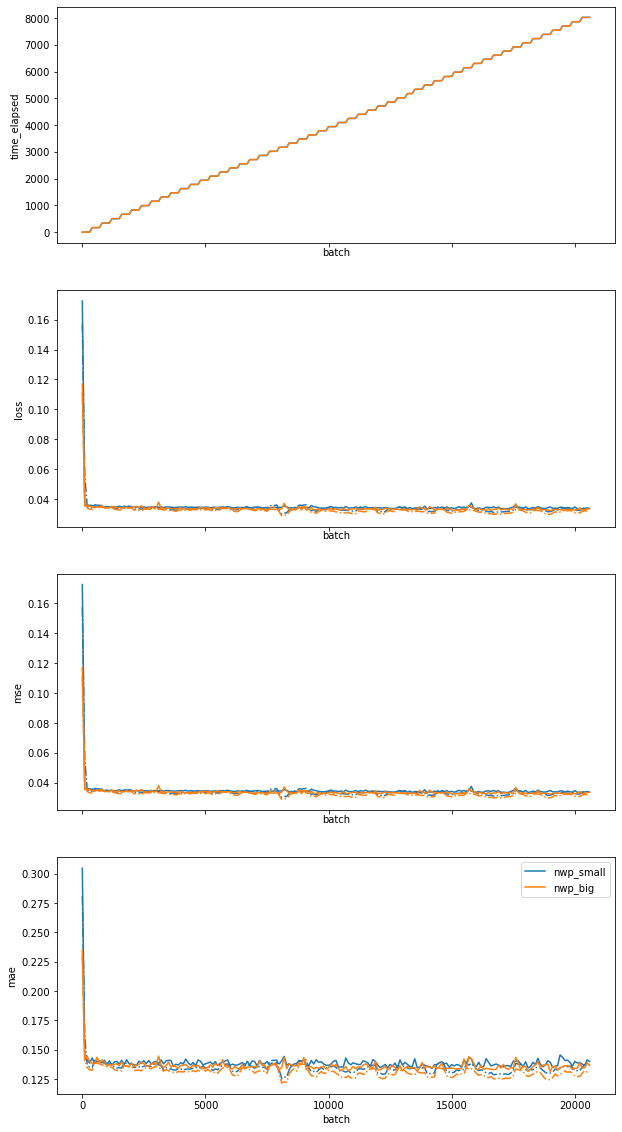

In [42]:
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']


fig, axes = plt.subplots(4,1, sharex=True, figsize=(10,20))
axes = axes.flatten()
plot_metrics = ['time_elapsed', 'loss', 'mse', 'mae']

for ax, metric in zip(axes, plot_metrics):
    colors = cycle(prop_cycle.by_key()['color'])
    
    for i in range(len(model_dumps)):
        c = next(colors)
        if metric=='time_elapsed':
            ax.plot(dfs[i].index, dfs[i][metric], label=model_dumps[i], color=c)
        else:
            ax.plot(dfs[i].index, dfs[i]['train_'+metric], linestyle='-.', color=c)
            ax.plot(dfs[i].index, dfs[i]['test_'+metric], linestyle='-', label=model_dumps[i], color=c)
    ax.set_xlabel('batch')
    ax.set_ylabel(metric)
ax.legend()
plt.show()

In [43]:
final_results_df = {}
for i,model in enumerate(model_dumps):
    df = dfs[i].iloc[-100:].mean()
    for ind in df.index:
        if ind in final_results_df.keys():
            final_results_df[ind].append(df[ind])
        else:
            final_results_df[ind] = [df[ind]] 
pd.DataFrame(final_results_df, index=model_dumps).sort_values('test_loss')

,time_elapsed,train_loss,train_mse,train_mae,test_loss,test_mse,test_mae
nwp_big,6121.416787,0.031588,0.031588,0.129252,0.033302,0.033302,0.135439
nwp_small,6121.307393,0.033057,0.033057,0.133393,0.034248,0.034248,0.138096
